## Austin Harrison | https://colab.research.google.com/drive/1RNpBL2fGUyfd8M_bqZ0r23RH6HaGWLoj?usp=sharing

In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from random import randint

def img_plt(images, labels):
  plt.figure(figsize=[15,8])
  for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(images[i-1,:,:], cmap='gray')
    plt.title('Label: ' + str(labels[i-1]))
  plt.show()

def feat_extract(images):
  width = images.shape[1]
  height = images.shape[2]
  features = np.zeros((images.shape[0], 4))
  # Quadrant 0
  features_temp = np.sum(images[:,0:int(width/2),0:int(height/2)],axis=2)
  features[:,0] = np.sum(features_temp, axis=1)/(width*height/4)
  # Quadrant 1
  features_temp = np.sum(images[:,0:int(width/2),int(height/2):],axis=2)
  features[:,1] = np.sum(features_temp, axis=1)/(width*height/4)
  # Quadrant 2
  features_temp = np.sum(images[:,int(width/2):,0:int(height/2)],axis=2)
  features[:,2] = np.sum(features_temp, axis=1)/(width*height/4)
  # Quadrant 3
  features_temp = np.sum(images[:,int(width/2):,int(height/2):],axis=2)
  features[:,3] = np.sum(features_temp, axis=1)/(width*height/4)

  return features

def feat_plot(features, labels, classes):
  for class_i in range(len(classes)):
    plt.plot(features[labels[:]==classes[class_i],0],
             features[labels[:]==classes[class_i],1],'o', markersize=15)
  #plt.axis([-2,2,-2,2])
  plt.xlabel('x: feature 1')
  plt.ylabel('y: feature 2')
  plt.legend(['Class'+str(classes[class_i]) for class_i in range(len(classes))])
  plt.show()

def acc_fun(labels_actual, labels_pred):
  acc = np.sum(labels_actual==labels_pred)/len(labels_actual)*100
  return acc

# Loading MNIST dataset and selecting only the 0,3,and 8 digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
classes = [0,3,8]

x_train_038 = x_train[np.logical_or.reduce((y_train==0, y_train==3, y_train==8)), 0:28,0:28]
y_train_038 = y_train[np.logical_or.reduce((y_train==0, y_train==3, y_train==8))]
print("Samples of Training Images")
img_plt(x_train_038[0:10,:,:], y_train_038[0:10])

x_test_038 = x_test[np.logical_or.reduce((y_test==0, y_test==3, y_test==8)), 0:28,0:28]
y_test_038 = y_test[np.logical_or.reduce((y_test==0, y_test==3, y_test==8))]
print("Samples of Testing Images")
img_plt(x_test_038[0:10,:,:], y_test_038[0:10])

# Shuffling training data
num_train_img = x_train_038.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
x_train_038 = x_train_038[train_ind_s, :, :]
y_train_038 = y_train_038[train_ind_s]
# Selecting 500 images for validation set
x_val_038 = x_train_038[0:500, :, :]
y_val_038 = y_train_038[0:500]
# The rest of the training set
x_train_038 = x_train_038[500:, :, :]
y_train_038 = y_train_038[500:]
print("Samples of the validation images")
img_plt(x_val_038[0:10,:,:], y_val_038[0:10])

# Calculating training, validation, and testing feature
feature_train = feat_extract(x_train_038)
feature_val = feat_extract(x_val_038)
feature_test = feat_extract(x_test_038)

print("Plotting the features of 500 training images: ")
feat_plot(feature_train[1:500, 0:2], y_train_038[1:500], classes)
feat_plot(feature_train[1:500, 2:4], y_train_038[1:500], classes)



In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

def plot_curve(accuracy_train, loss_train):
  epochs = np.arange(loss_train.shape[0])
  plt.subplot(1,2,1)
  plt.plot(epochs, accuracy_train)
  #plt.axis([-1,2,-1,2])
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training Accuracy")

  plt.subplot(1,2,2)
  plt.plot(epochs, loss_train)
  plt.xlabel("Epochs")
  plt.ylabel("Binary Crossentropy Loss")
  plt.title("Training Loss")
  plt.show()

# Defining the model
model = Sequential()
model.add(Dense(input_dim=4, units=256, activation="tanh"))
model.add(Dense(units=16, activation="tanh"))
model.add(Dense(units=len(classes), activation="softmax"))
model.summary()
# Compiling model
opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer = opt,
              metrics=["accuracy"])


from keras.utils import to_categorical
labelMap = {0: 0, 3: 1, 8: 2}
y_train_038_mapped = np.vectorize(labelMap.get)(y_train_038)
y_val_038_mapped = np.vectorize(labelMap.get)(y_val_038)
y_test_038_mapped = np.vectorize(labelMap.get)(y_test_038)
# Converting class vectors to binary class metrics
num_classes = len(classes)
y_train_038_c = to_categorical(y_train_038_mapped, num_classes)
y_val_038_c = to_categorical(y_val_038_mapped, num_classes)
y_test_038_c = to_categorical(y_test_038_mapped, num_classes)

history = model.fit(feature_train, y_train_038_c,
                    validation_data = (feature_val, y_val_038_c),
                    batch_size=16,
                    epochs=30,
                    verbose=1)

# Evaluating model on training samples
score = model.evaluate(feature_train, y_train_038_c)
print("Total loss on training set: ", score[0])
print("Accuracy of training set: ", score[1])

score = model.evaluate(feature_val, y_val_038_c)
print("Total loss on validation set: ", score[0])
print("Accuracy of validation set: ", score[1])

plt.figure(figsize=[9,5])
acc_curve = np.array(history.history['accuracy'])
loss_curve = np.array(history.history['loss'])
plot_curve(acc_curve, loss_curve)

Training Model 1: 1 layer, 16 nodes
Epoch 1/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.2398 - accuracy: 0.3450 - val_loss: 1.1809 - val_accuracy: 0.3300
Epoch 2/30
1088/1088 [==============================] - 3s 3ms/step - loss: 1.1317 - accuracy: 0.3602 - val_loss: 1.1209 - val_accuracy: 0.3420
Epoch 3/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.0969 - accuracy: 0.3739 - val_loss: 1.0981 - val_accuracy: 0.3520
Epoch 4/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.0817 - accuracy: 0.3832 - val_loss: 1.0896 - val_accuracy: 0.3540
Epoch 5/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.0745 - accuracy: 0.3894 - val_loss: 1.0864 - val_accuracy: 0.3600
Epoch 6/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.0702 - accuracy: 0.3937 - val_loss: 1.0843 - val_accuracy: 0.3600
Epoch 7/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.0668 - accuracy: 0.396

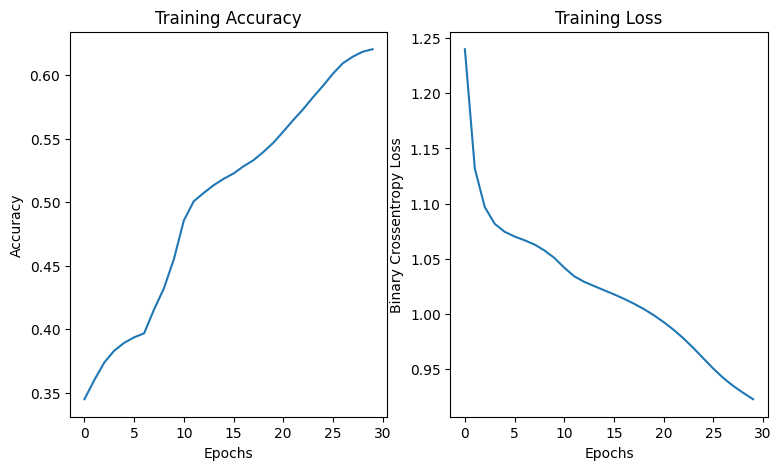

16/16 [==============================] - 0s 2ms/step - loss: 0.9373 - accuracy: 0.5860
Training Model 2: 1 layer, 64 nodes
Epoch 1/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.2814 - accuracy: 0.3545 - val_loss: 1.1229 - val_accuracy: 0.4240
Epoch 2/30
1088/1088 [==============================] - 2s 2ms/step - loss: 1.0446 - accuracy: 0.4766 - val_loss: 0.9930 - val_accuracy: 0.5400
Epoch 3/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.9749 - accuracy: 0.5270 - val_loss: 0.9500 - val_accuracy: 0.5540
Epoch 4/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.9429 - accuracy: 0.5593 - val_loss: 0.9257 - val_accuracy: 0.5720
Epoch 5/30
1088/1088 [==============================] - 3s 3ms/step - loss: 0.9204 - accuracy: 0.5779 - val_loss: 0.9084 - val_accuracy: 0.5840
Epoch 6/30
1088/1088 [==============================] - 3s 2ms/step - loss: 0.9023 - accuracy: 0.5913 - val_loss: 0.8930 - val_accuracy: 0.5900
Epoch 7/30
10

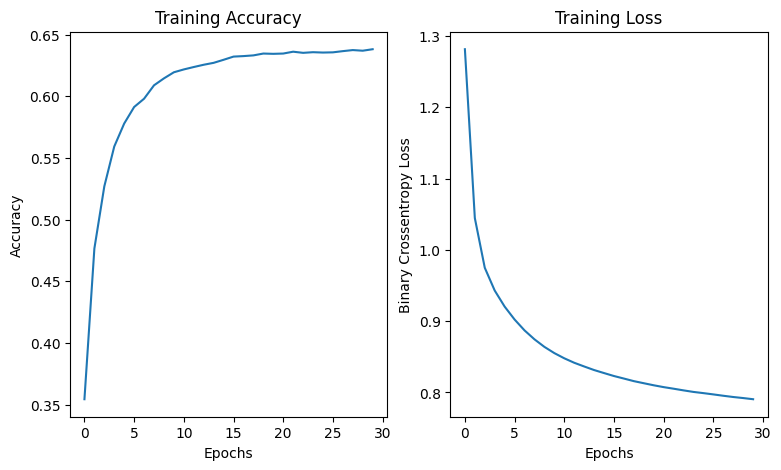

16/16 [==============================] - 0s 2ms/step - loss: 0.7972 - accuracy: 0.6180
Training Model 3: 1 layer, 128 nodes
Epoch 1/30
1088/1088 [==============================] - 3s 2ms/step - loss: 1.0778 - accuracy: 0.4938 - val_loss: 0.9263 - val_accuracy: 0.5900
Epoch 2/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.9024 - accuracy: 0.6043 - val_loss: 0.8801 - val_accuracy: 0.6380
Epoch 3/30
1088/1088 [==============================] - 3s 2ms/step - loss: 0.8623 - accuracy: 0.6272 - val_loss: 0.8552 - val_accuracy: 0.6420
Epoch 4/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.8390 - accuracy: 0.6376 - val_loss: 0.8373 - val_accuracy: 0.6400
Epoch 5/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.8231 - accuracy: 0.6421 - val_loss: 0.8235 - val_accuracy: 0.6460
Epoch 6/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.8110 - accuracy: 0.6461 - val_loss: 0.8139 - val_accuracy: 0.6340
Epoch 7/30
1

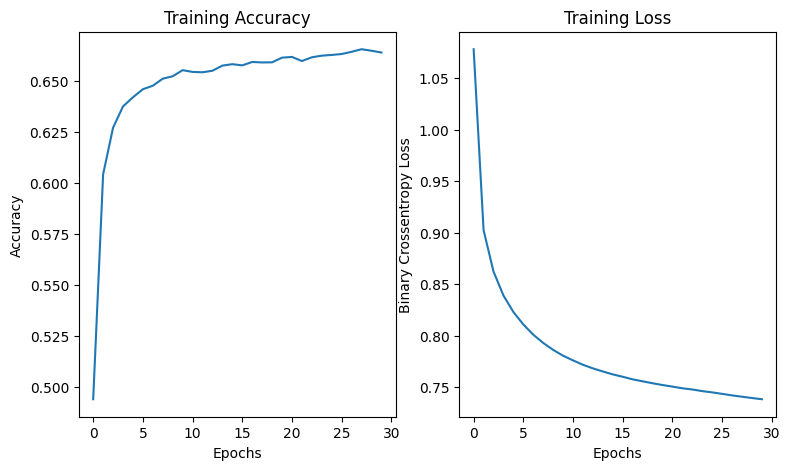

16/16 [==============================] - 0s 2ms/step - loss: 0.7425 - accuracy: 0.6660
Training Model 4: 2 layer, 128 nodes, 16 nodes
Epoch 1/30
1088/1088 [==============================] - 3s 2ms/step - loss: 0.9633 - accuracy: 0.5348 - val_loss: 0.8670 - val_accuracy: 0.6000
Epoch 2/30
1088/1088 [==============================] - 3s 3ms/step - loss: 0.8533 - accuracy: 0.6361 - val_loss: 0.8312 - val_accuracy: 0.6480
Epoch 3/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.8252 - accuracy: 0.6509 - val_loss: 0.8159 - val_accuracy: 0.6540
Epoch 4/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.8083 - accuracy: 0.6573 - val_loss: 0.8032 - val_accuracy: 0.6540
Epoch 5/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.7955 - accuracy: 0.6594 - val_loss: 0.7915 - val_accuracy: 0.6540
Epoch 6/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.7861 - accuracy: 0.6624 - val_loss: 0.7839 - val_accuracy: 0.6500
Ep

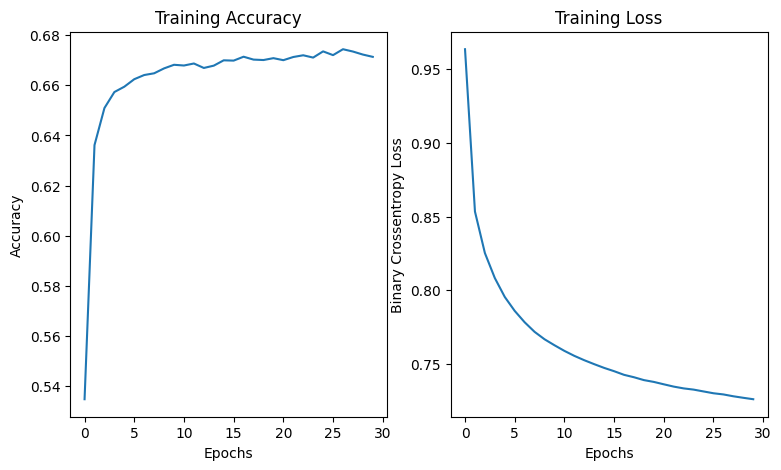

16/16 [==============================] - 0s 3ms/step - loss: 0.7289 - accuracy: 0.6740
Training Model 5: 2 layer, 128 nodes, 64 nodes
Epoch 1/30
1088/1088 [==============================] - 3s 2ms/step - loss: 1.0071 - accuracy: 0.5147 - val_loss: 0.9043 - val_accuracy: 0.5840
Epoch 2/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.8702 - accuracy: 0.6253 - val_loss: 0.8512 - val_accuracy: 0.6140
Epoch 3/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.8292 - accuracy: 0.6383 - val_loss: 0.8164 - val_accuracy: 0.6360
Epoch 4/30
1088/1088 [==============================] - 3s 3ms/step - loss: 0.8054 - accuracy: 0.6464 - val_loss: 0.7980 - val_accuracy: 0.6420
Epoch 5/30
1088/1088 [==============================] - 3s 3ms/step - loss: 0.7904 - accuracy: 0.6522 - val_loss: 0.7857 - val_accuracy: 0.6440
Epoch 6/30
1088/1088 [==============================] - 2s 2ms/step - loss: 0.7793 - accuracy: 0.6558 - val_loss: 0.7768 - val_accuracy: 0.6460
Ep

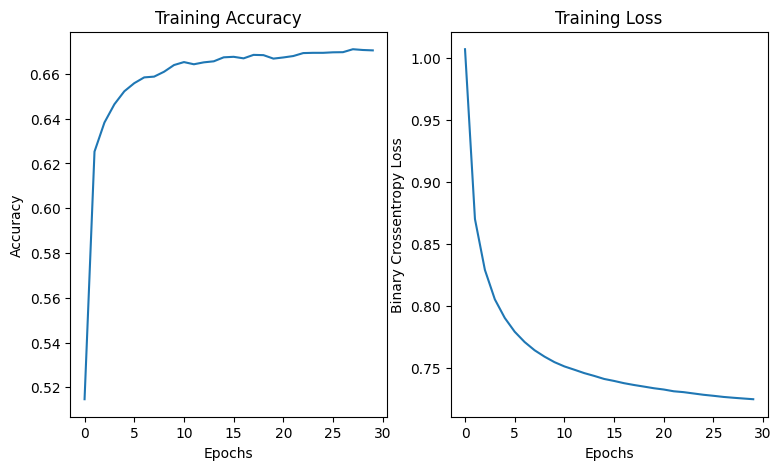

16/16 [==============================] - 0s 2ms/step - loss: 0.7307 - accuracy: 0.6660


In [ ]:
# Creating the models with different nodes and layers
model_1 = Sequential([
    Dense(units=16, activation="tanh", input_dim=4),
    Dense(units=len(classes), activation="softmax")
])
model_2 = Sequential([
    Dense(units=64, activation="tanh", input_dim=4),
    Dense(units=len(classes), activation="softmax")
])
model_3 = Sequential([
    Dense(units=128, activation="tanh", input_dim=4),
    Dense(units=len(classes), activation="softmax")
])
model_4 = Sequential([
    Dense(units=128, activation="tanh", input_dim=4),
    Dense(units=16, activation="tanh"),
    Dense(units=len(classes), activation="softmax")
])
model_5 = Sequential([
    Dense(units=128, activation="tanh", input_dim=4),
    Dense(units=64, activation="tanh"),
    Dense(units=len(classes), activation="softmax")
])

models = [model_1, model_2, model_3, model_4, model_5]
for model in models:
  opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
  model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

model_details = [
    ("1 layer, 16 nodes", model_1),
    ("1 layer, 64 nodes", model_2),
    ("1 layer, 128 nodes", model_3),
    ("2 layer, 128 nodes, 16 nodes", model_4),
    ("2 layer, 128 nodes, 64 nodes", model_5),
]

results = []
for i, (desc, model) in enumerate(model_details, start=1):
  print(f"Training Model {i}: {desc}")
  history = model.fit(feature_train, y_train_038_c,
                      validation_data=(feature_val, y_val_038_c),
                      batch_size=16,
                      epochs=30,
                      verbose=1)
  plt.figure(figsize=[9,5])
  acc_curve = np.array(history.history['accuracy'])
  loss_curve = np.array(history.history['loss'])
  plot_curve(acc_curve, loss_curve)
  train_loss, train_acc = model.evaluate(feature_train, y_train_038_c)
  val_loss, val_acc = model.evaluate(feature_val, y_val_038_c)
  results.append((desc, train_loss, train_acc, val_loss, val_acc))

In [ ]:
# Evaluating on testing set
test_loss, test_acc = model_1.evaluate(feature_test, y_test_038_c)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_acc)

test_loss, test_acc = model_2.evaluate(feature_test, y_test_038_c)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_acc)

test_loss, test_acc = model_3.evaluate(feature_test, y_test_038_c)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_acc)

test_loss, test_acc = model_4.evaluate(feature_test, y_test_038_c)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_acc)

test_loss, test_acc = model_5.evaluate(feature_test, y_test_038_c)
print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_acc)

93/93 [==============================] - 1s 8ms/step - loss: 0.8426 - accuracy: 0.6002
Testing Loss: 0.8426017165184021
Testing Accuracy: 0.6002024412155151
93/93 [==============================] - 1s 10ms/step - loss: 0.7492 - accuracy: 0.6471
Testing Loss: 0.7491762042045593
Testing Accuracy: 0.6470985412597656
93/93 [==============================] - 0s 4ms/step - loss: 0.7365 - accuracy: 0.6515
Testing Loss: 0.7364500164985657
Testing Accuracy: 0.651484489440918
93/93 [==============================] - 0s 4ms/step - loss: 0.7439 - accuracy: 0.6630
Testing Loss: 0.7438564300537109
Testing Accuracy: 0.6629554629325867
93/93 [==============================] - 0s 2ms/step - loss: 0.7469 - accuracy: 0.6491
Testing Loss: 0.746914803981781
Testing Accuracy: 0.6491228342056274


### **Conclusion**: The behavior I see is that loss decreases and accuracy increases over the first 3 models but after the third model loss increases from 3 to 5 while accuracy increases before begining to decrease at model 5.  With these in mind model 4 seems to be the most suitable for this probelem as its testing loss is the 2nd lowest and has the highest accuracy of all 5 models.